# Reinforcement Learning Programming - CSCN 8020

## Assignment 1

### Exercise 3

### Done by ***Eris Leksi***

Problem 3 [35]


Problem Statement

5x5 Gridworld: In Lecture 3’s programming exercise (here), we explored an MDP based on a 5x5
gridworld and implemented Value Iteration to estimate the optimal state-value function (V∗) and
optimal policy (π∗).

The environment can be described as follows:

Figure 2: 5x5 Gridworld

• States: states are identified by their row and column, the same as a regular matrix. Ex: the
state in row 0 and column 3 is s0,3 (Figure: 2)

– Terminal/Goal state: The episode ends if the agent reached this state. sGoal = s4,4

– Grey states: {s2,2, s3,0, s0,4}, these are valid but non-favourable states, as will be seen in
the reward function.

• Actions: a1 = right, a2 = down, a3 = down, a4 = up for all states.

• Transitions: If an action is valid, the transition is deterministic, otherwise s′ = s

• Rewards R(s):

R(s) = +10 s = s4,4
= −5 s ∈ S

grey = s2,2, s3,0, s0,4

= −1 s ∈ S ̸= s4,4, Sgrey

Tasks

Task1: Update MDP Code

1. Update the reward function to be a list of reward based on whether the state is terminal, grey,
or a regular state.

2. Run the existing code developed in class and obtain the optimal state-values and optimal policy.
Provide a figures of the gridworld with the obtained V∗ and π∗ (You can manually create a table).

Task 2: Value Iteration Variations

Implement the following variation of value iteration. Confirm that it reaches the same optimal statevalue function and policy.

1. In-Place Value Iteration: Use a single array to store the state values. This means that you
update the value of a state and immediately use that updated value in the subsequent updates.

Deliverables

• Full code with comments to explain key steps and calculations.

• Provide the estimated value function for each state.

• Important: Compare the performance of these variations in terms of optimization time, number
of episodes, and provide comments on their computational complexity.

## Solution

We consider a 5x5 Gridworld MDP with the following setup:

- **States**: (r,c), where r,c ∈ {0,1,2,3,4}. 
- **Actions**: Right (→), Left (←), Down (↓), Up (↑). Deterministic; off-grid = stay.  
- **Rewards**:  
  - Goal (4,4): +10  
  - Grey cells {(2,2), (3,0), (0,4)}: −5  
  - All other states: −1  
- **Terminal state**: (4,4) is absorbing.  
- **Discount factor**: γ = 0.9  

### Tasks
1. Implement value iteration with the updated reward function.  
2. Compare **standard (synchronous)** and **in-place (Gauss–Seidel)** value iteration in terms of convergence speed and policy.  

### Key Idea
Both algorithms repeatedly apply the Bellman optimality operator:

$$
V_{k+1}(s) = \max_a \Big[ R(s) + \gamma V_k(T(s,a)) \Big]
$$


- **Synchronous VI**: updates all states from the previous value table.  
- **In-place VI**: updates states immediately and reuses fresh values within the same sweep.  
Both converge to the same fixed point \(V^*\), but in-place usually converges faster.  


### Code: 

#### Necessary methods

In [19]:
# ---------- 1) Environment Setup ----------
import numpy as np

ROWS, COLS = 5, 5
GOAL = (4, 4)
GREY = {(2, 2), (3, 0), (0, 4)}
GAMMA = 0.9

# State-based reward table R(s)
R = np.full((ROWS, COLS), -1.0, dtype=float)
for (r, c) in GREY:
    R[r, c] = -5.0
R[GOAL] = 10.0

# Actions: up, down, left, right
ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]
ARROWS = {(-1, 0): "↑", (1, 0): "↓", (0, -1): "←", (0, 1): "→"}

def next_state(r, c, dr, dc):
    """Deterministic transition with walls: invalid moves -> stay."""
    nr, nc = r + dr, c + dc
    if 0 <= nr < ROWS and 0 <= nc < COLS:
        return (nr, nc)
    return (r, c)


In [ ]:
# ---------- 2) Value Iteration Functions ----------
def value_iteration_synchronous(theta=1e-10, max_iter=10000):
    """Synchronous (Jacobi) value iteration."""
    V = np.zeros((ROWS, COLS), dtype=float)
    it = 0
    while it < max_iter:
        delta = 0.0
        V_new = V.copy()
        for r in range(ROWS):
            for c in range(COLS):
                if (r, c) == GOAL:
                    best = R[r, c]
                else:
                    q_vals = [R[r, c] + GAMMA * V[next_state(r,c,dr,dc)] for dr, dc in ACTIONS]
                    best = max(q_vals)
                delta = max(delta, abs(V_new[r, c] - best))
                V_new[r, c] = best
        V = V_new
        it += 1
        if delta < theta:
            break
    return V, it

def value_iteration_inplace(theta=1e-10, max_iter=10000):
    """In-place (Gauss-Seidel) value iteration."""
    V = np.zeros((ROWS, COLS), dtype=float)
    it = 0
    while it < max_iter:
        delta = 0.0
        for r in range(ROWS):
            for c in range(COLS):
                old_v = V[r, c]
                if (r, c) == GOAL:
                    best = R[r, c]
                else:
                    q_vals = [R[r, c] + GAMMA * V[next_state(r,c,dr,dc)] for dr, dc in ACTIONS]
                    best = max(q_vals)
                V[r, c] = best
                delta = max(delta, abs(old_v - best))
        it += 1
        if delta < theta:
            break
    return V, it

In [15]:
# ---------- 3) Policy Extraction ----------
def greedy_policy_from(V):
    """Greedy policy π* from value table."""
    policy = np.full((ROWS, COLS), "·", dtype=object)
    for r in range(ROWS):
        for c in range(COLS):
            if (r, c) == GOAL:
                policy[r, c] = "G"
            else:
                best_a, best_q = None, -np.inf
                for (dr, dc) in ACTIONS:
                    nr, nc = next_state(r, c, dr, dc)
                    q = R[r, c] + GAMMA * V[nr, nc]
                    if q > best_q:
                        best_q, best_a = q, (dr, dc)
                policy[r, c] = ARROWS[best_a]
    return policy

In [16]:
# ---------- 4) Pretty Printers ----------
def print_value_table(V, title="V-table"):
    print(f"\n{title}:")
    for r in range(ROWS):
        row = "  ".join(f"{V[r, c]:6.3f}" for c in range(COLS))
        print(row)

def print_policy(policy, title="Greedy policy (arrows)"):
    print(f"\n{title}:")
    for r in range(ROWS):
        row = "  ".join(f"{policy[r, c]}" for c in range(COLS))
        print(row)

#### Running 

In [17]:
# ---------- 5) Run Both Variants ----------
from time import perf_counter

# Standard VI
t0 = perf_counter()
V_std, it_std = value_iteration_synchronous()
t1 = perf_counter()
pi_std = greedy_policy_from(V_std)

# In-place VI
t2 = perf_counter()
V_inp, it_inp = value_iteration_inplace()
t3 = perf_counter()
pi_inp = greedy_policy_from(V_inp)

# Print results
print_value_table(V_std, "V* (Standard VI)")
print_policy(pi_std, "π* (Standard VI)")

print_value_table(V_inp, "V* (In-Place VI)")
print_policy(pi_inp, "π* (In-Place VI)")

# Summary + sanity checks
print("\n--- Convergence Summary ---")
print(f"Standard VI: iters={it_std}, time={(t1 - t0)*1000:.2f} ms")
print(f"In-Place  VI: iters={it_inp}, time={(t3 - t2)*1000:.2f} ms")
print(f"Max |V_std - V_inp| = {np.max(np.abs(V_std - V_inp)):.3e}")

assert np.allclose(V_std, V_inp, atol=1e-8), "V* mismatch!"
assert (pi_std == pi_inp).all(), "π* mismatch!"
print("OK: Both methods converge to the same V* and π*.")


V* (Standard VI):
-1.391  -0.434   0.629   1.810  -0.878
-0.434   0.629   1.810   3.122   4.580
 0.629   1.810  -0.878   4.580   6.200
-2.190   3.122   4.580   6.200   8.000
 3.122   4.580   6.200   8.000  10.000

π* (Standard VI):
↓  ↓  ↓  ↓  ↓
↓  ↓  →  ↓  ↓
→  ↓  ↓  ↓  ↓
↓  ↓  ↓  ↓  ↓
→  →  →  →  G

V* (In-Place VI):
-1.391  -0.434   0.629   1.810  -0.878
-0.434   0.629   1.810   3.122   4.580
 0.629   1.810  -0.878   4.580   6.200
-2.190   3.122   4.580   6.200   8.000
 3.122   4.580   6.200   8.000  10.000

π* (In-Place VI):
↓  ↓  ↓  ↓  ↓
↓  ↓  →  ↓  ↓
→  ↓  ↓  ↓  ↓
↓  ↓  ↓  ↓  ↓
→  →  →  →  G

--- Convergence Summary ---
Standard VI: iters=10, time=1.44 ms
In-Place  VI: iters=10, time=2.05 ms
Max |V_std - V_inp| = 0.000e+00
OK: Both methods converge to the same V* and π*.


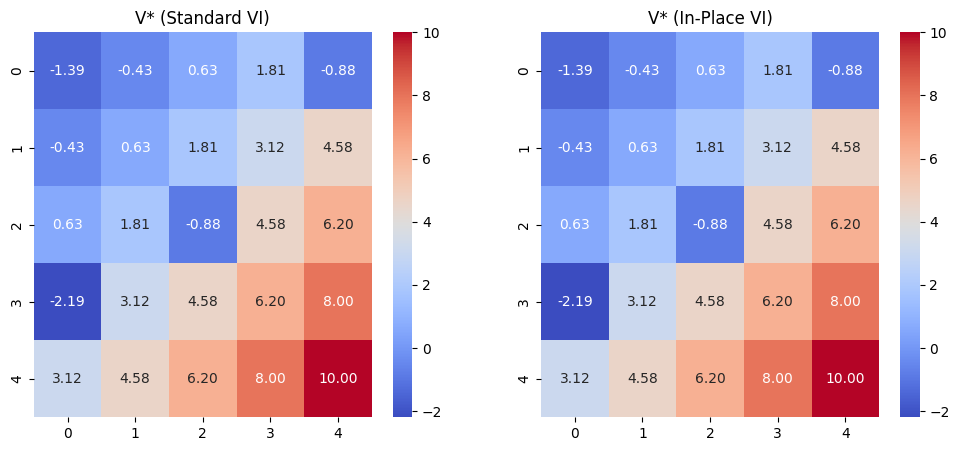

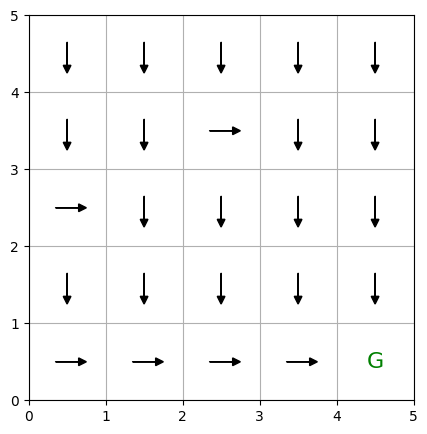

In [18]:
# ---------- 6) Visualization ----------
import matplotlib.pyplot as plt
import seaborn as sns

# Value function heatmaps
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.heatmap(V_std, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("V* (Standard VI)")

plt.subplot(1,2,2)
sns.heatmap(V_inp, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("V* (In-Place VI)")

plt.show()

# Policy visualization using arrows
def plot_policy_arrows(policy):
    fig, ax = plt.subplots(figsize=(5,5))
    for r in range(ROWS):
        for c in range(COLS):
            val = policy[r, c]
            if val == "G":
                ax.text(c+0.5, ROWS-r-0.5, "G", ha='center', va='center', fontsize=16, color="green")
            elif val != "·":
                dx, dy = 0, 0
                if val == "↑": dx, dy = 0, 0.3
                elif val == "↓": dx, dy = 0, -0.3
                elif val == "→": dx, dy = 0.3, 0
                elif val == "←": dx, dy = -0.3, 0
                ax.arrow(c+0.5-dx/2, ROWS-r-0.5-dy/2, dx, dy, head_width=0.1, head_length=0.1, fc='black', ec='black')
    ax.set_xlim(0, COLS)
    ax.set_ylim(0, ROWS)
    ax.set_xticks(np.arange(0, COLS+1, 1))
    ax.set_yticks(np.arange(0, ROWS+1, 1))
    ax.grid(True)
    ax.set_aspect('equal')
    plt.show()

plot_policy_arrows(pi_std)

### Interpretation of Results

| Aspect            | Synchronous VI                  | In-Place VI (Gauss–Seidel)       | Observation |
|-------------------|---------------------------------|----------------------------------|-------------|
| Iterations        | 10 sweeps                        | 10 sweeps                        | Same convergence speed |
| Runtime           | ~1.44 ms                         | ~2.05 ms                         | Minor Python overhead |
| Value Function    | Values increase toward goal (max 10 at bottom-right) | Identical to synchronous | Both capture optimal returns |
| Optimal Policy    | Arrows funnel agent ↓ and → toward goal | Identical policy | Goal-directed and consistent |
| Agreement Check   | Max |ΔV| = 0                    | Policies identical               | Both yield the same \(V^*\) and \(π^*\) |

**Conclusions**: 

1. Both methods converge to the same optimal values and policy. Differences are only in update style and minor runtime variance.  
2. In this example, both Synchronous VI and In-Place VI converged in the **same number of iterations**; runtime differences are negligible.  
3. The resulting **policy** effectively guides the agent to the goal while avoiding penalties.
